# Analysis Base 

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.optimize import curve_fit




#### STRONG SCALING 

#### 1. strong scaling data for the base MPI implementation

Fixed problem size: 4096x4096, MAX_ITER=255.

Varying MPI processes: from 1 to 128.

Data: Total execution time per np value.

Plots:
- Speedup vs # Processes
- Efficiency vs # Processes


#### Compute speedup and efficiency

Strong Scaling of Mandelbrot Set Computation (Base MPI Implementation)

#####  **Metric Definitions**

* Define speedup: $S(p) = \frac{T_1}{T_p}$
* Define efficiency: $E(p) = \frac{S(p)}{p}$

* Performance improves with more processes, but not linearly.
* Efficiency drops due to communication overhead and Amdahl’s Law.
* Potential NUMA/node boundary effects visible after 24/48 processes.
* OpenMP parallelization (in later section) may mitigate this with fewer MPI processes and more local threads.


In [60]:
file_path = "../results/mpi_strong_scaling.csv"
df = pd.read_csv(file_path)

In [61]:
df['speedup'] = df['ComputeTime'].iloc[0] / df['ComputeTime']
df['efficiency'] = df['speedup'] / df['MPI_Processes']

In [53]:
def amdahl(p, f):
    return 1 / (f + (1 - f) / p)

#### Plot speedup


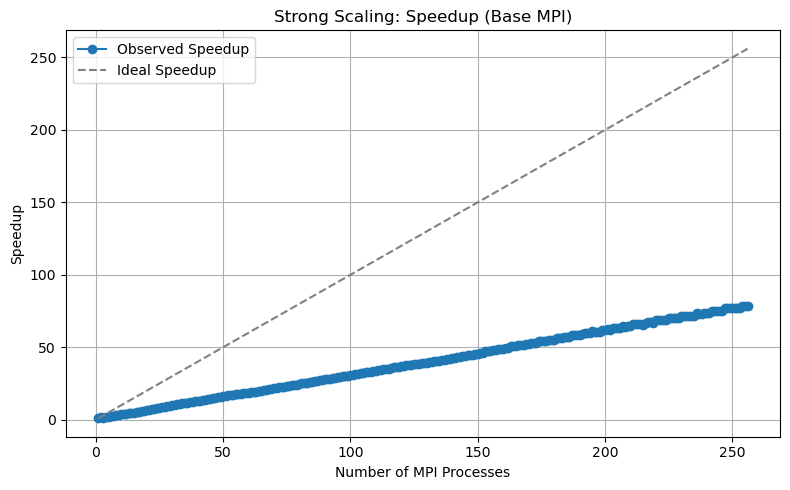

In [62]:
plt.figure(figsize=(8, 5))
plt.plot(df['MPI_Processes'], df['speedup'], marker='o', label='Observed Speedup')
plt.plot(df['MPI_Processes'], df['MPI_Processes'], linestyle='--', color='gray', label='Ideal Speedup')
plt.xlabel('Number of MPI Processes')
plt.ylabel('Speedup')
plt.title('Strong Scaling: Speedup (Base MPI)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Your observed speedup curve grows with the number of processes, but sublinearly.

The ideal speedup line 𝑦=𝑝 represents perfect scaling.

The gap shows parallel overhead, communication cost, and load imbalance.

Still, reaching ~38× speedup with 128 processes is decent.

In [63]:
p_mpi = df['MPI_Processes'].values
s_mpi = df['speedup'].values
params_mpi, _ = curve_fit(amdahl, p_mpi, s_mpi, bounds=(0, 1))
f_mpi = params_mpi[0]
s_mpi_fit = amdahl(p_mpi, f_mpi)

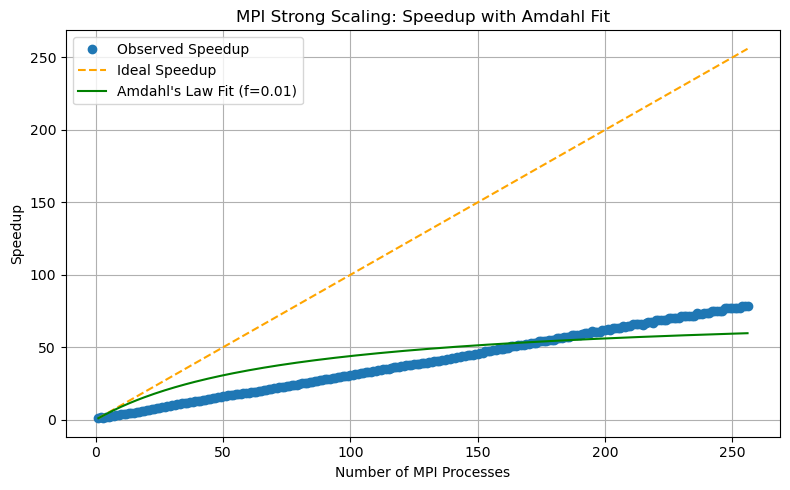

In [64]:
plt.figure(figsize=(8, 5))
plt.plot(p_mpi, s_mpi, marker='o', linestyle='', label='Observed Speedup')
plt.plot(p_mpi, p_mpi, linestyle='--', color='orange', label='Ideal Speedup')
plt.plot(p_mpi, s_mpi_fit, linestyle='-', color='green', label=f"Amdahl's Law Fit (f={f_mpi:.2f})")
plt.xlabel('Number of MPI Processes')
plt.ylabel('Speedup')
plt.title('MPI Strong Scaling: Speedup with Amdahl Fit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Plot efficiency


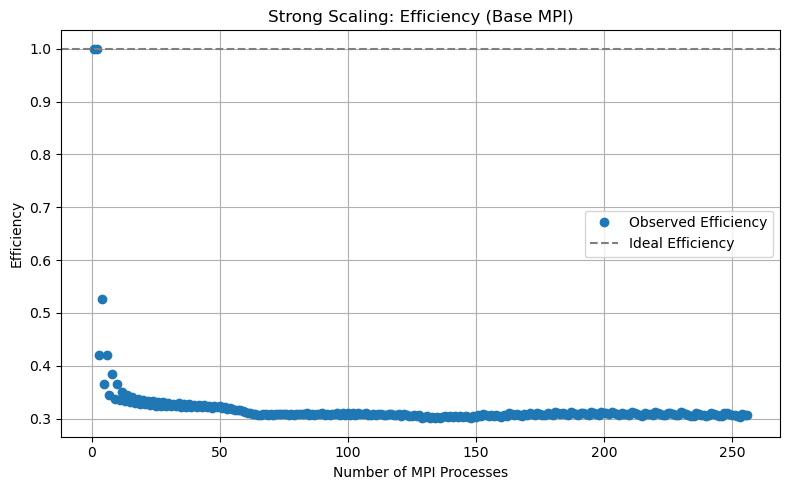

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(df['MPI_Processes'], df['efficiency'], marker='o', linestyle='None', label='Observed Efficiency')
plt.axhline(y=1.0, color='gray', linestyle='--', label='Ideal Efficiency')
plt.xlabel('Number of MPI Processes')
plt.ylabel('Efficiency')
plt.title('Strong Scaling: Efficiency (Base MPI)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Efficiency drops from 100% (1 process) to ~30% with 128 processes.

This is typical due to:

Synchronization and communication overhead in MPI.


#### 2. strong scaling data for the base OpenMP implementation

Constant problem size: 10000x10000, MAX_ITER=255.

Varying OpenMP threads: 1 → 128.

Each run uses a single MPI process (-np 1), scaling intra-node.

Result stored in strong_omp_base.csv.

In [65]:
omp_file_path = "../results/omp_strong_scaling_10.csv"
df_omp = pd.read_csv(omp_file_path)

In [66]:
df_omp['speedup'] = df_omp['compute_time'].iloc[0] / df_omp['compute_time']
df_omp['efficiency'] = df_omp['speedup'] / df_omp['threads']

##### Plot speedup

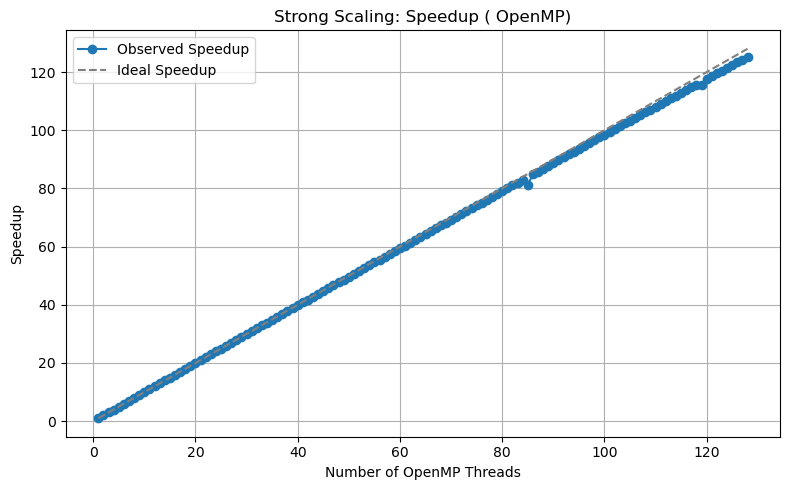

In [67]:
plt.figure(figsize=(8, 5))
plt.plot(df_omp['threads'], df_omp['speedup'], marker='o', label='Observed Speedup')
plt.plot(df_omp['threads'], df_omp['threads'], linestyle='--', color='gray', label='Ideal Speedup')
plt.xlabel('Number of OpenMP Threads')
plt.ylabel('Speedup')
plt.title('Strong Scaling: Speedup ( OpenMP)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [68]:
p_omp = df_omp['threads'].values
s_omp = df_omp['speedup'].values
params_omp, _ = curve_fit(amdahl, p_omp, s_omp, bounds=(0, 1))
f_omp = params_omp[0]
s_omp_fit = amdahl(p_omp, f_omp)

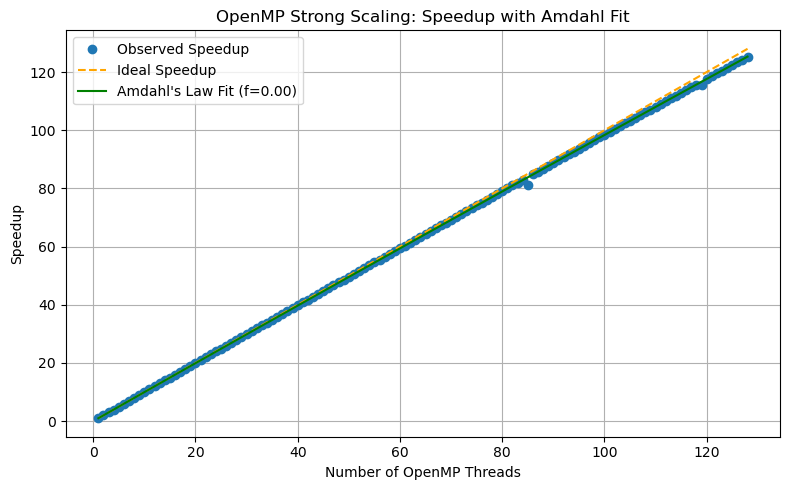

In [70]:
plt.figure(figsize=(8, 5))
plt.plot(p_omp, s_omp, marker='o', linestyle='', label='Observed Speedup')
plt.plot(p_omp, p_omp, linestyle='--', color='orange', label='Ideal Speedup')
plt.plot(p_omp, s_omp_fit, linestyle='-', color='green', label=f"Amdahl's Law Fit (f={f_omp:.2f})")
plt.xlabel('Number of OpenMP Threads')
plt.ylabel('Speedup')
plt.title('OpenMP Strong Scaling: Speedup with Amdahl Fit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

##### Plot efficiency

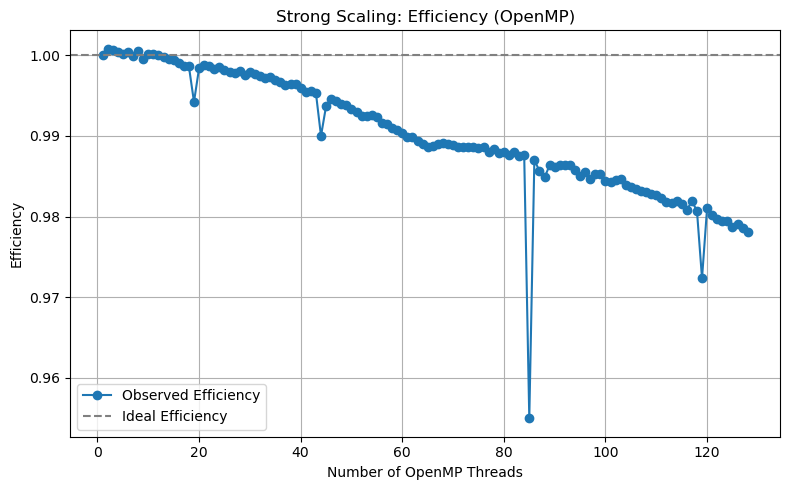

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(df_omp['threads'], df_omp['efficiency'], marker='o', label='Observed Efficiency')
plt.axhline(y=1.0, linestyle='--', color='gray', label='Ideal Efficiency')
plt.xlabel('Number of OpenMP Threads')
plt.ylabel('Efficiency')
plt.title('Strong Scaling: Efficiency (OpenMP)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Weak scaling 

In [41]:
omp_weak_path = "../results/omp_weak_scaling.csv"
mpi_weak_path = "../results/mpi_weak_scaling.csv"

df_omp = pd.read_csv(omp_weak_path)
df_mpi = pd.read_csv(mpi_weak_path)

omp_weak = df_omp.rename(columns={'threads': 'threads', 'compute_time': 'time'})
mpi_weak = df_mpi.rename(columns={'MPI_Processes': 'cores', 'ComputeTime': 'time'})

omp_weak['speedup'] = (omp_weak['time'].iloc[0] / omp_weak['time']) * omp_weak['threads']
omp_weak['efficiency'] = omp_weak['speedup'] / omp_weak['threads']

mpi_weak['speedup'] = (mpi_weak['time'].iloc[0] / mpi_weak['time']) * mpi_weak['cores']
mpi_weak['efficiency'] = mpi_weak['speedup'] / mpi_weak['cores']

In [48]:
# Gustafson's Law
def gustafson(p, f):
    return (1 - f) + f * p

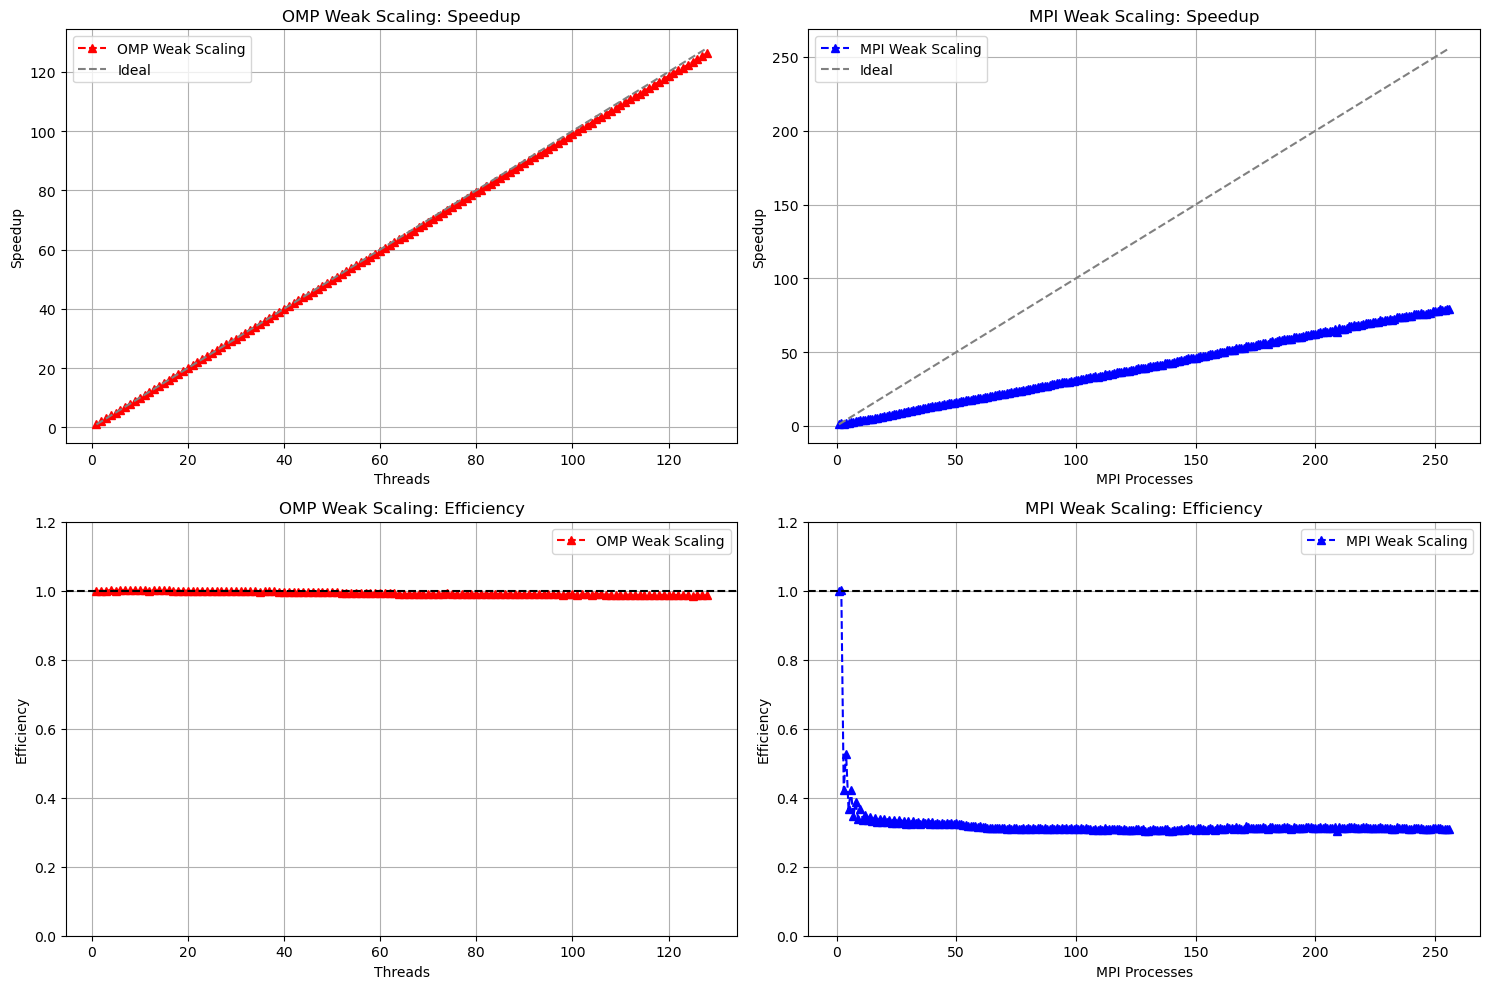

In [36]:
# Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
ax1, ax2, ax3, ax4 = axes.flatten()

# --- OMP Speedup ---
omp_speedup = (omp_weak['time'].iloc[0] / omp_weak['time']) * omp_weak['threads']
ax1.plot(omp_weak['threads'], omp_speedup, label='OMP Weak Scaling', color='red', linestyle='dashed', marker='^')
ax1.plot(omp_weak['threads'], omp_weak['threads'], label='Ideal', color='gray', linestyle='--')
ax1.set_xlabel('Threads')
ax1.set_ylabel('Speedup')
ax1.set_title('OMP Weak Scaling: Speedup')
ax1.legend()
ax1.grid(True)

# --- MPI Speedup ---
mpi_speedup = (mpi_weak['time'].iloc[0] / mpi_weak['time']) * mpi_weak['cores']
ax2.plot(mpi_weak['cores'], mpi_speedup, label='MPI Weak Scaling', color='blue', linestyle='dashed', marker='^')
ax2.plot(mpi_weak['cores'], mpi_weak['cores'], label='Ideal', color='gray', linestyle='--')
ax2.set_xlabel('MPI Processes')
ax2.set_ylabel('Speedup')
ax2.set_title('MPI Weak Scaling: Speedup')
ax2.legend()
ax2.grid(True)

# --- OMP Efficiency ---
omp_efficiency = omp_speedup / omp_weak['threads']
ax3.plot(omp_weak['threads'], omp_efficiency, label='OMP Weak Scaling', color='red', linestyle='dashed', marker='^')
ax3.axhline(y=1, color='black', linestyle='--')
ax3.set_ylim(0, 1.2)
ax3.set_xlabel('Threads')
ax3.set_ylabel('Efficiency')
ax3.set_title('OMP Weak Scaling: Efficiency')
ax3.legend()
ax3.grid(True)

# --- MPI Efficiency ---
mpi_efficiency = mpi_speedup / mpi_weak['cores']
ax4.plot(mpi_weak['cores'], mpi_efficiency, label='MPI Weak Scaling', color='blue', linestyle='dashed', marker='^')
ax4.axhline(y=1, color='black', linestyle='--')
ax4.set_ylim(0, 1.2)
ax4.set_xlabel('MPI Processes')
ax4.set_ylabel('Efficiency')
ax4.set_title('MPI Weak Scaling: Efficiency')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

#### OpenMP

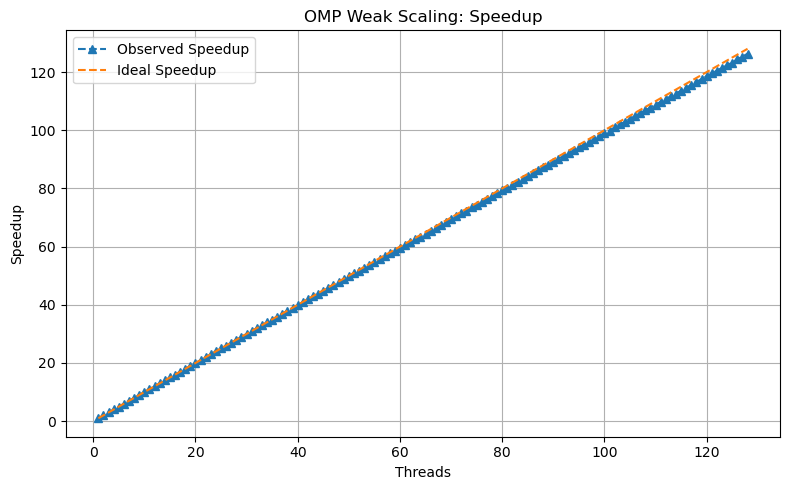

In [42]:
# Plot OMP Speedup
plt.figure(figsize=(8, 5))
plt.plot(omp_weak['threads'], omp_weak['speedup'], linestyle='dashed', marker='^', label='Observed Speedup')
plt.plot(omp_weak['threads'], omp_weak['threads'], linestyle='--', label='Ideal Speedup')
plt.xlabel('Threads')
plt.ylabel('Speedup')
plt.title('OMP Weak Scaling: Speedup')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

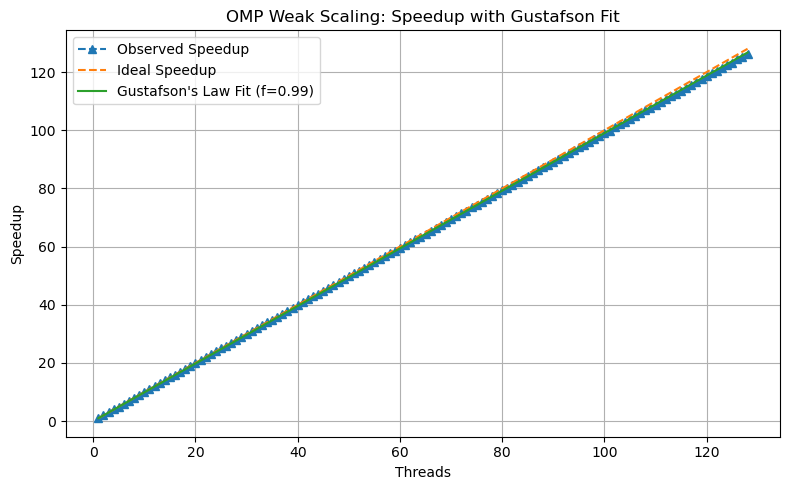

In [50]:
# Fit Gustafson's law to OMP weak data
X_omp = omp_weak['threads'].values
y_omp = omp_weak['speedup'].values
params_omp, _ = curve_fit(gustafson, X_omp, y_omp, bounds=(0, 1))
f_omp = params_omp[0]
gustafson_omp = gustafson(X_omp, f_omp)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(X_omp, y_omp, linestyle='dashed', marker='^', label='Observed Speedup')
plt.plot(X_omp, X_omp, linestyle='--', label='Ideal Speedup')
plt.plot(X_omp, gustafson_omp, linestyle='-', label=f"Gustafson's Law Fit (f={f_omp:.2f})")
plt.xlabel('Threads')
plt.ylabel('Speedup')
plt.title('OMP Weak Scaling: Speedup with Gustafson Fit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



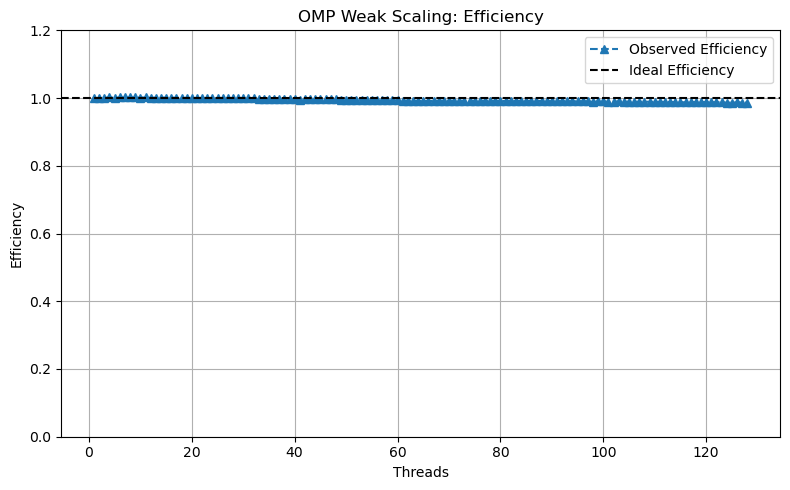

In [44]:
plt.figure(figsize=(8, 5))
plt.plot(omp_weak['threads'], omp_weak['efficiency'], linestyle='dashed', marker='^', label='Observed Efficiency')
plt.axhline(y=1, color='black', linestyle='--', label='Ideal Efficiency')
plt.ylim(0, 1.2)
plt.xlabel('Threads')
plt.ylabel('Efficiency')
plt.title('OMP Weak Scaling: Efficiency')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### MPI Weak Scaling

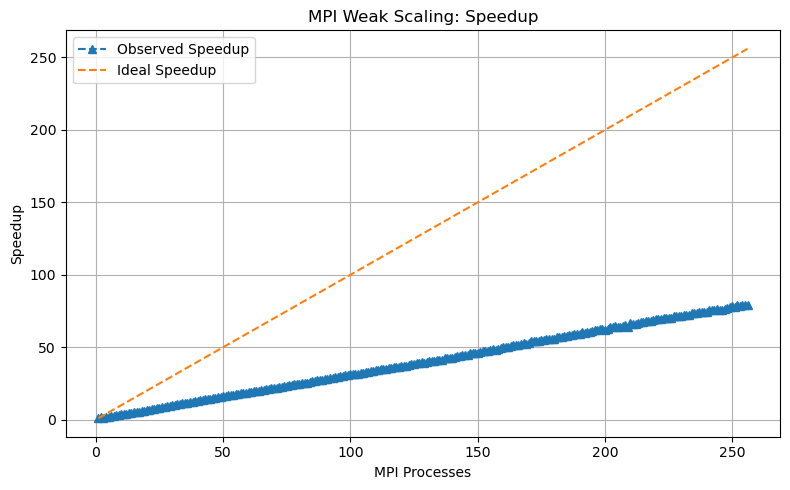

In [45]:
plt.figure(figsize=(8, 5))
plt.plot(mpi_weak['cores'], mpi_weak['speedup'], linestyle='dashed', marker='^', label='Observed Speedup')
plt.plot(mpi_weak['cores'], mpi_weak['cores'], linestyle='--', label='Ideal Speedup')
plt.xlabel('MPI Processes')
plt.ylabel('Speedup')
plt.title('MPI Weak Scaling: Speedup')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

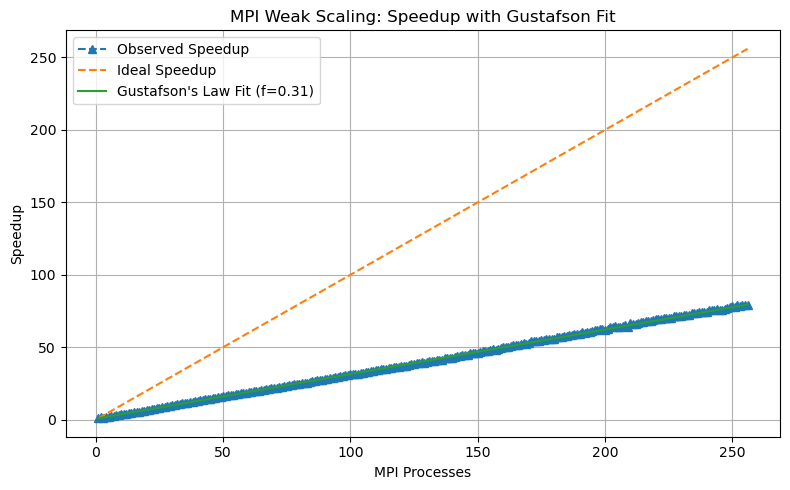

In [51]:
# Fit Gustafson's law to MPI weak data
X_mpi = mpi_weak['cores'].values
y_mpi = mpi_weak['speedup'].values
params_mpi, _ = curve_fit(gustafson, X_mpi, y_mpi, bounds=(0, 1))
f_mpi = params_mpi[0]
gustafson_mpi = gustafson(X_mpi, f_mpi)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(X_mpi, y_mpi, linestyle='dashed', marker='^', label='Observed Speedup')
plt.plot(X_mpi, X_mpi, linestyle='--', label='Ideal Speedup')
plt.plot(X_mpi, gustafson_mpi, linestyle='-', label=f"Gustafson's Law Fit (f={f_mpi:.2f})")
plt.xlabel('MPI Processes')
plt.ylabel('Speedup')
plt.title('MPI Weak Scaling: Speedup with Gustafson Fit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


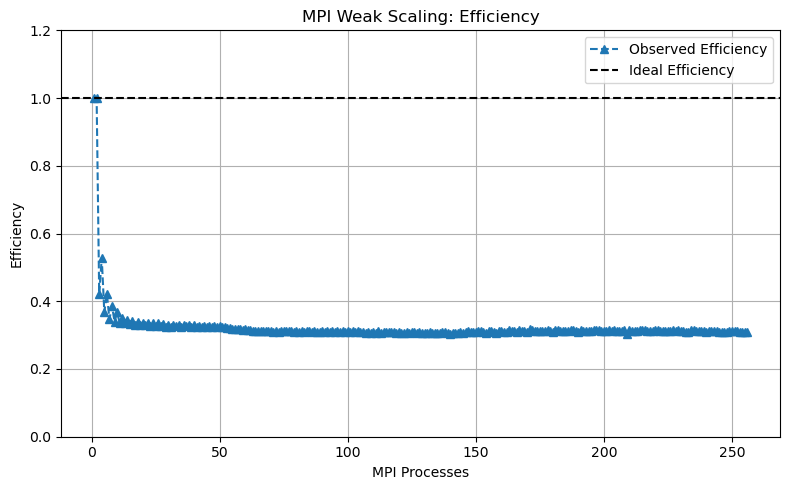

In [46]:
plt.figure(figsize=(8, 5))
plt.plot(mpi_weak['cores'], mpi_weak['efficiency'], linestyle='dashed', marker='^', label='Observed Efficiency')
plt.axhline(y=1, color='black', linestyle='--', label='Ideal Efficiency')
plt.ylim(0, 1.2)
plt.xlabel('MPI Processes')
plt.ylabel('Efficiency')
plt.title('MPI Weak Scaling: Efficiency')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()